# Stack Overflow 2022 Developer Survey Analysis

In this notebook, i'm going to analyze the 2022 Developer Survey of Stack Overflow users. The survey recolected data about education, careers, finance, culture, demographics and more.

I will try to answer the following questions:
* At what companies do developers get paid the most?
* How much does remote working matter to employees?
* How does coding experience affect the level of pay?
* What's the most popular method of learning to code?
* Are you more likely to get a job as a developer if you have a master's degree?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# Read the dataset
# survey = pd.read_csv('survey_results_public.csv', quoting=3, sep=",")
survey = pd.read_csv('survey_results_public.csv')

In [3]:
# See the first 3 rows of the data
survey.head(3)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,...,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0


In [4]:
# See info of the dataset
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5694 entries, 0 to 5693
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ResponseId                      5694 non-null   int64  
 1   MainBranch                      5694 non-null   object 
 2   Employment                      5640 non-null   object 
 3   RemoteWork                      4748 non-null   object 
 4   CodingActivities                4747 non-null   object 
 5   EdLevel                         5638 non-null   object 
 6   LearnCode                       5638 non-null   object 
 7   LearnCodeOnline                 4122 non-null   object 
 8   LearnCodeCoursesCert            1773 non-null   object 
 9   YearsCode                       5623 non-null   object 
 10  YearsCodePro                    4202 non-null   object 
 11  DevType                         4889 non-null   object 
 12  OrgSize                         41

We can see that there are a lot of columns that contains a lot of null values. In the case that i need to fix them, i will do it.

## At what companies do developers get paid the most?

To answer this question, we need to use the data of these columns:
* OrgSize: The size of the organization where the users works
* CompTotal: The total compensation (salary, bonuses, and perks before taxes and deductions)
* CompFreq: The frequency of the compensation

In [5]:
# Lets see the type of frequencies that exists
survey['CompFreq'].value_counts()

Yearly     2142
Monthly    1423
Weekly       91
Name: CompFreq, dtype: int64

In [6]:
# Count null values
survey['CompFreq'].isna().sum()

2038

We can see that are a lot of null values. This is probably because those users are not working as a developer. I want to see the total of null values in Comptotal to compare

In [7]:
survey['CompTotal'].isna().sum()

2496

We can that they are not to equal, but at least they are not too far. I'm going to left null those values, because i can't assume someone compensation if he really does not work as a developer.

Now, i'm going to apply a function to the dataframe that calculates the compensation for each row, depending on the Total and Frequency features.

In [8]:
# Define a function that multiplies the compensation for his frequency:
def compensation_multiplier(row):
  frequency = row.CompFreq
  if frequency == 'Yearly':
    return row.CompTotal * 1
  elif frequency == 'Monthly':
    # I assume that developers have 3 weeks of vacations a year
    return row.CompTotal * 11.25
  elif frequency == 'Weekly':
    # 49 weeks is 11 months and 1 week.
    return row.CompTotal * 49
  else:
    return 'Nan'
  

In [9]:
# Apply the function and store the values in a variable
final_comp_values = survey.apply(compensation_multiplier, axis='columns')

In [10]:
# Assign the values to the new column
survey['FinalCompt'] = final_comp_values

In [11]:
# Transform to integers the values
survey['FinalCompt'] = survey['FinalCompt'].astype('float')

We can see the different types of organizations and their frequency with value_counts.

In [12]:
survey['OrgSize'].value_counts()

20 to 99 employees                                    854
100 to 499 employees                                  777
10,000 or more employees                              623
1,000 to 4,999 employees                              453
500 to 999 employees                                  347
2 to 9 employees                                      321
10 to 19 employees                                    319
5,000 to 9,999 employees                              204
Just me - I am a freelancer, sole proprietor, etc.    194
I don’t know                                           71
Name: OrgSize, dtype: int64

Now, i'm going to calculate the mean for each type of organization, to know in which one developers get paid the most according to the survey.

In [13]:
# Calculate the mean for each type of organization
mean_comp_by_orgsize = survey.groupby('OrgSize')['FinalCompt'].mean().reset_index()
sorted_mean_comp_by_orgsize = mean_comp_by_orgsize.sort_values(by='FinalCompt')
sorted_mean_comp_by_orgsize.rename(columns={'FinalCompt': 'MeanCompensation'}, inplace=True)
sorted_mean_comp_by_orgsize

,OrgSize,MeanCompensation
8,I don’t know,2.734032e+05
7,500 to 999 employees,2.189719e+06
4,2 to 9 employees,2.555009e+06
0,"1,000 to 4,999 employees",2.805448e+06
1,10 to 19 employees,3.142749e+06
6,"5,000 to 9,999 employees",4.731029e+06
9,"Just me - I am a freelancer, sole proprietor, ...",5.317221e+06
3,100 to 499 employees,1.320667e+07
5,20 to 99 employees,2.094448e+07
2,"10,000 or more employees",9.702970e+50


We can appreciate that where developers get paid the most, are in the companies with 5000 to 9999 employees. And the ones that win less, are the freelancers.

## How much does remote working matter to employees?

Here, we are interested in the employment and the remote work features. We need to see for each type of eployment the % of remote workers, to see how much they care about the possibility to work remotely.

In [14]:
survey['Employment'].value_counts()

Employed, full-time                                                                                                                                                              3594
Student, full-time                                                                                                                                                                506
Independent contractor, freelancer, or self-employed                                                                                                                              314
Employed, full-time;Independent contractor, freelancer, or self-employed                                                                                                          240
Not employed, but looking for work                                                                                                                                                131
Student, full-time;Employed, part-time                                                    

There are a lot of different answers in this question. It's not efficient to see for each one the % of work. I notice that exists people searching for a job, so i'm going to check if people that is actually looking for work answered the question of 'RemoteWork'.

In [15]:
# Create the DF with the job searchers and then print the amount of null values in remote work
job_searchers = survey[survey['Employment'].fillna('None').str.contains('but looking for work')]
job_searchers.RemoteWork.isna().sum()

186

In [16]:
# print the shape of the df: (rows, columns) 
job_searchers.shape

(223, 80)

We can appreciate that most of the people that are looking for job didn't answered the the RemoteWork question. So we are just going to use the RemoteWork column

In [17]:
value_counts = survey['RemoteWork'].value_counts()
value_counts

Fully remote                            2087
Hybrid (some remote, some in-person)    1967
Full in-person                           694
Name: RemoteWork, dtype: int64

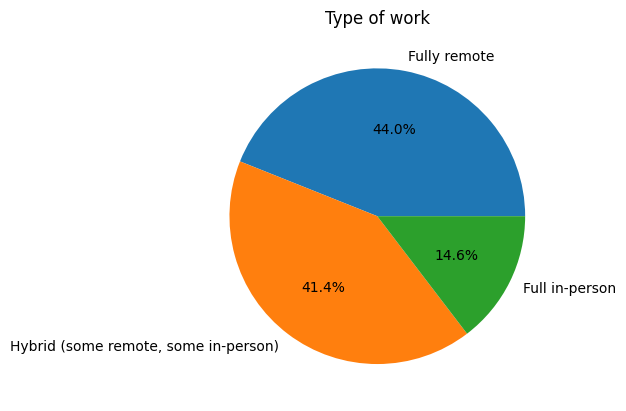

<Figure size 800x400 with 0 Axes>

In [18]:
# Create a pie plot
value_counts.plot(kind='pie', ylabel='', autopct='%1.1f%%')
plt.title('Type of work')
plt.figure(figsize=(8,4))
# Display the plot
plt.show()

The majority of the people that answered the question works remote or wants to do it. So, we can say that is actually pretty relevant for the Stack Overflow users to work in this way nowadays. We are not considering the null values in the plot, because they are irrelevant since are empty answers to that question in the survey.

## How does coding experience affect the level of pay?

To answer this question, we have to take care of the YearsCode, CompFreq and TotalComp features of our dataset. YearsCodePro is not relevant, because years of coding pro quantity is inside of years coding for someone. For example, if i have been coding for 10 years, and 2 years as a professional, my coding experience still being of 10 years.

In [19]:
# First we need to fill the none values of the coding column
survey.YearsCode = survey.YearsCode.fillna(0)

In [20]:
# survey.YearsCode = survey.YearsCode.astype('int64')
survey.YearsCode.unique()

array([0, '14', '20', '8', '15', '3', '1', '6', '37', '5', '12', '22',
       '11', '4', '7', '13', '36', '2', '25', '10', '40', '16', '27',
       '24', '19', '9', '17', '18', '26', 'More than 50 years', '29',
       '30', '32', 'Less than 1 year', '48', '45', '38', '39', '28', '23',
       '43', '21', '41', '35', '50', '33', '31', '34', '46', '44', '42',
       '47'], dtype=object)

They are two values that are strings. We are going to round them to 1 and 50, and then convert the dtype to integer.

In [21]:
# survey.loc[(survey.YearsCode == 'Less than 1 year')]
survey.loc[survey['YearsCode'] == 'Less than 1 year', 'YearsCode'] = '1'
survey.loc[survey['YearsCode'] == 'More than 50 years', 'YearsCode'] = '50'

In [22]:
survey.YearsCode = survey.YearsCode.astype('int64')

Now we are going to calculate the correlation between years of code and the FinalCompt. First we need to fill the FinalCompt nan values with 0, because in YearsCode we don't have any nan values.

In [23]:
survey.FinalCompt = survey.FinalCompt.fillna(0)

In [24]:
correlation = survey['YearsCode'].corr(survey['FinalCompt'])
print(correlation)

-0.0030308242402721053


We can see that according to the survey, there is negative correlation that is very close to 0. So, we can say that is not too important the coding experience according to the salaries. I think that is because it depends in a lot of another factors, such as degree, company type, role and amount of useful knowledge to do the specific job.

## What's the most popular method of learning to code?

To answer this question, we need to use the columns about code learning. We need to focus on the LearnCode feature. Running the cell above, we can see that there are a lot of different answers, because one person can learn by different methods. Each person responded with all the ways they learned to code.

In [25]:
survey.LearnCode.head(10)
# We can appreciate that each answer is separated by ';'

0                                                  NaN
1                                                  NaN
2    Books / Physical media;Friend or family member...
3    Books / Physical media;School (i.e., Universit...
4    Other online resources (e.g., videos, blogs, f...
5    Books / Physical media;School (i.e., Universit...
6    Other online resources (e.g., videos, blogs, f...
7                      Online Courses or Certification
8                  On the job training;Coding Bootcamp
9    Books / Physical media;Other online resources ...
Name: LearnCode, dtype: object

In [26]:
# separate each answer by the ; string
answers_list = survey['LearnCode'].str.split(';')

# drop the null values 
answers_list = answers_list.dropna()

# get all the values for each row in a list
all_answers = [answer for answers in answers_list for answer in answers]

print(all_answers)

['Books / Physical media', 'Friend or family member', 'Other online resources (e.g., videos, blogs, forum)', 'School (i.e., University, College, etc)', 'Books / Physical media', 'School (i.e., University, College, etc)', 'Other online resources (e.g., videos, blogs, forum)', 'School (i.e., University, College, etc)', 'On the job training', 'Books / Physical media', 'School (i.e., University, College, etc)', 'Other online resources (e.g., videos, blogs, forum)', 'Online Courses or Certification', 'On the job training', 'Coding Bootcamp', 'Books / Physical media', 'Other online resources (e.g., videos, blogs, forum)', 'School (i.e., University, College, etc)', 'Books / Physical media', 'Friend or family member', 'Other online resources (e.g., videos, blogs, forum)', 'School (i.e., University, College, etc)', 'Other online resources (e.g., videos, blogs, forum)', 'School (i.e., University, College, etc)', 'Books / Physical media', 'School (i.e., University, College, etc)', 'Other online r

In [27]:
answer_counts = pd.Series(all_answers).value_counts()
answer_counts

Other online resources (e.g., videos, blogs, forum)    4129
School (i.e., University, College, etc)                3673
Books / Physical media                                 3175
Online Courses or Certification                        2113
On the job training                                    2102
Colleague                                               927
Friend or family member                                 833
Coding Bootcamp                                         433
Hackathons (virtual or in-person)                       398
Other (please specify):                                 306
dtype: int64

We can see all the different methods of how people learned how to code! Videos and blogs were the most popular, very close to school.

Text(0.5, 1.0, 'How people learned to code')

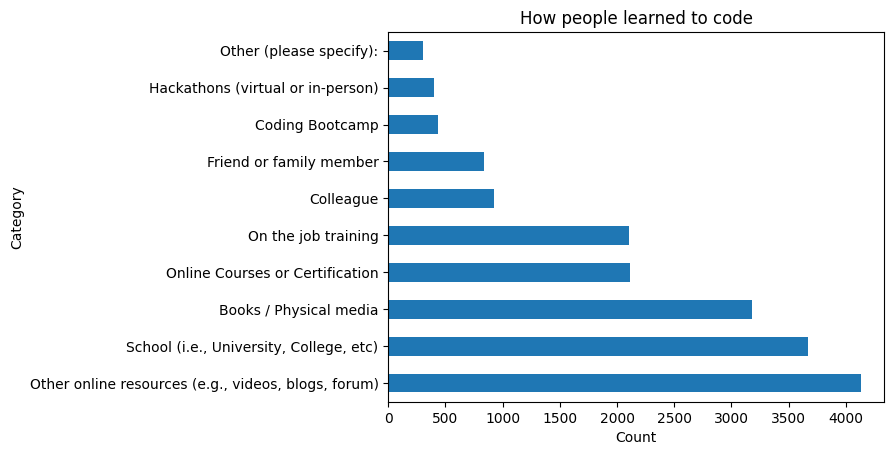

In [28]:
# Create a horizontal bar chart
answer_counts.plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('How people learned to code')

## Are you more likely to get a job as a developer if you have a master's degree?

To answer this question, we need to use the columns of Employment, and EdLevel.  

In [29]:
survey['EdLevel'].unique()

array([nan, 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Some college/university study without earning a degree',
       'Something else', 'Primary/elementary school',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)'], dtype=object)

The answers are too long. I'm going to eliminate the characters between "()", because it's irrelevant.

In [36]:
# use regular expressions to eliminate the information between ()
import re
survey['EdLevel'] = survey['EdLevel'].str.replace(r'\(.*\)', '', regex=True)
survey['EdLevel'] = survey['EdLevel'].str.strip()
survey['EdLevel'].unique()

array([nan, 'Master’s degree', 'Bachelor’s degree', 'Secondary school',
       'Some college/university study without earning a degree',
       'Something else', 'Primary/elementary school',
       'Other doctoral degree', 'Associate degree', 'Professional degree'],
      dtype=object)

In [46]:
# create a df just from people that are employed
employed = survey[survey['Employment'].fillna('None').str.contains('Employed')]
len(employed)

4355

For all the people that are employed, let' see the different types of work.

In [49]:
employed['MainBranch'].unique()

array(['I am a developer by profession',
       'I am not primarily a developer, but I write code sometimes as part of my work',
       'I code primarily as a hobby',
       'I used to be a developer by profession, but no longer am',
       'I am learning to code'], dtype=object)

Let's filter the employed to just get the developers, and then see the value counts for their education level.

In [53]:
developers = employed.loc[(employed.MainBranch == 'I am a developer by profession')]
developers.EdLevel.value_counts()

Bachelor’s degree                                         1977
Master’s degree                                            953
Some college/university study without earning a degree     436
Secondary school                                           167
Associate degree                                           115
Other doctoral degree                                      109
Professional degree                                         48
Primary/elementary school                                   35
Something else                                              30
Name: EdLevel, dtype: int64

We can see that by far, the people that answered the survey and work as developer just have a Bachelors' degree, not a Master's degree.
So, we can't say that someone is more likely to get a job as a developer having a master's degree. For curiosity, let's see what are the most popular professions among the people that have master's degree.

In [58]:
masters = employed.loc[(employed.EdLevel == 'Master’s degree')]
masters.MainBranch.value_counts()

I am a developer by profession                                                   953
I am not primarily a developer, but I write code sometimes as part of my work    110
I used to be a developer by profession, but no longer am                          20
I code primarily as a hobby                                                        7
I am learning to code                                                              4
Name: MainBranch, dtype: int64

By far the most popular profession for people with a master's degre that answered the survey is as a developer. So definitely having a master's degree does not really get you more chances of being hired as a developer in a company. I think that they are another factors that are more relevant.